In [4]:
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
# import tf_clahe
import tensorflow_addons as tfa
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os, sys
from tensorflow.image import resize_with_pad, grayscale_to_rgb
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
import re                               # regular expression: is a special sequence of characters that helps you match or find other strings or sets of strings
import numpy                            # Python package used for scientific computing. Contains a powerful n-dim array object
import matplotlib.pyplot as plt         # matplotlib for plotting graphs
%matplotlib inline
from random import randint 
import random             
from glob import glob                   # finds all the pathnames matching a specified patter
import pandas as pd   
import cv2 as cv                  

print(tf.__version__)

image_size = 1024

output_size = 512
#epochs = 500

# zip_path = '/content/drive/MyDrive/mias-dataset.zip'
datadir = '/mnt/c/Users/user/Desktop/mias-dataset/mias-dataset/'

from statistics import mean

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.3
Num GPUs Available:  1


In [5]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


In [6]:
def read_pgm(filename, byteorder='>'):                     # '>' indicates big-endian
  """Return image data from a raw PGM file as a numpy array.

  Format specification: http://netpbm.sourceforge.net/doc/pgm.html

  """

  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(  
    b"(^P5\s(?:\s*#.*[\r\n])*"                             # A pgm image's magic number is the two characters "P5"
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A width, formatted as ASCII characters in decimal
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A height, again in ASCII decimal
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()       # The maximum gray value (Maxval), again in ASCII decimal. 
                                                           # Must be less than 65536, and more than zero.
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
    
  return numpy.frombuffer(buffer,
               dtype='u1' if int(maxval) < 256 else byteorder+'u2',
               count=int(width)*int(height),
               offset=len(header)
              ).reshape((int(height)*int(width)))


def import_images(image_dir, num_images, train_test_split):
  # Create an array to hold all of the images, each of which is image_sizeximage_size
  images_tensor = numpy.zeros((1, image_size*image_size))
  # Create a tensor for the labels
  i = 0; j=0; k=0
  if (image_dir.split('/')[-2] == 'benign'): 
    category = 0
  elif (image_dir.split('/')[-2] == 'malignant'): 
    category = 1
  X = list(range(num_images))
  random.shuffle(X)
  train = int(num_images * train_test_split)
  test = num_images - train
  train_image = numpy.zeros((train,output_size,output_size,3))
  test_image = numpy.zeros((test,output_size,output_size,3))
  train_label = numpy.zeros((train))
  test_label = numpy.zeros((test))
  train_list = X[:train]
  test_list = X[-test:]
  print(train_list)
  print(test_list)
  f = open(datadir+str('/MIASInfo.txt'), 'r')
  line = f.readlines()
  for dirName, subdirList, fileList in os.walk(image_dir):
    for fname in fileList:
        if fname.endswith(".pgm") and i<num_images:
          images_tensor = read_pgm(image_dir+fname, byteorder='<')
          image_no = int(fname[3:6]) - 1
          if (i in train_list):
            new = clahe.apply(images_tensor)
            new = tf.convert_to_tensor(new,dtype=tf.float32)
            new = tf.reshape(new,[image_size,image_size,1])
            new = tf.image.grayscale_to_rgb(new)
            new = tfa.image.median_filter2d(new)
            l = line[image_no-1].split(" "); 
            if (str.isdigit(l[-3])):
              crop = new
              x = int(l[-3]); y = int(l[-2]); r = int(l[-1])
              crop = tf.image.crop_to_bounding_box(new,y-int(1.2*r),x-int(1.2*r),2*int(1.2*r),2*int(1.2*r))
              crop = tf.image.resize_with_pad(crop,output_size,output_size)
              # crop = tf_clahe.clahe(crop)
              train_image[j] = crop
              train_label[j] = category
              # print(str(image_no+1) + " train")
              j+=1
          elif (i in test_list):
            new = tf.convert_to_tensor(images_tensor,dtype=tf.float32)
            new = tf.reshape(new,[image_size,image_size,1])
            new_rgb = tf.image.grayscale_to_rgb(new)
            # crop = tf.image.crop_to_bounding_box(new,y-int(1.2*r),x-int(1.2*r),2*int(1.2*r),2*int(1.2*r))
            crop = tf.image.resize_with_pad(new_rgb,output_size,output_size)
            test_image[k] = crop
            test_label[k] = category
            # print(str(image_no+1) + " test")
            k+=1
          i+=1

  return train_image, train_label, test_image, test_label

def split_dataset(dir,train_test_split, benign_img, malignant_img):
  i=0;n=0;b=0;m=0
  B=int(benign_img*0.8); M=int(malignant_img*0.8); b=benign_img-B; m=malignant_img-M
  # train_b = numpy.zeros((B,image_size,image_size,3)); test_b = numpy.zeros((b,image_size,image_size,3))
  # trainb_label = numpy.zeros((B); testb_label = numpy.zeros((b))
  # train_m = numpy.zeros((M,image_size,image_size,3)); test_m = numpy.zeros((m,image_size,image_size,3))
  # trainm_label = numpy.zeros((M); testm_label = numpy.zeros((m)))
  print("Importing benign images")
  train_b, trainb_label, test_b, testb_label = import_images(dir+str('benign/'),benign_img, train_test_split)
  print("Importing malignant images")
  train_m, trainm_label, test_m, testm_label = import_images(dir+str('malignant/'),malignant_img, train_test_split)
  # train_amount = N+B+M
  # test_amount = n+b+m
  # train_set = numpy.zeros((train_amount,output_size,output_size,3))
  # train_label = numpy.zeros((train_amount,3))
  # test_set = numpy.zeros((test_amount,output_size,output_size,3)) 
  # test_label = numpy.zeros((test_amount,3))
  print('Combining data')
  train_image = tf.concat((
      train_b,
      train_m),0)
  test_image = tf.concat((
      test_b,
      test_m),0)
  train_label = numpy.concatenate((
      trainb_label,
      trainm_label))
  test_label = numpy.concatenate((
      testb_label,
      testm_label))
  img_size = output_size
  return (train_image, train_label), (test_image, test_label)

In [7]:
(train_set, train_label), (test_set,test_label) = split_dataset(datadir,0.8,50,50)

Importing benign images
[31, 17, 28, 20, 38, 44, 23, 43, 21, 30, 37, 0, 9, 41, 11, 25, 15, 46, 18, 32, 29, 5, 1, 26, 45, 34, 16, 48, 14, 3, 6, 19, 33, 40, 10, 24, 39, 49, 36, 2]
[42, 8, 7, 35, 12, 27, 47, 13, 4, 22]


2023-02-06 21:18:15.810470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 21:18:15.812074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 21:18:15.812134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-06 21:18:15.812149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

Importing malignant images
[25, 39, 35, 28, 14, 37, 40, 19, 49, 31, 29, 17, 1, 20, 43, 21, 9, 12, 13, 26, 45, 46, 8, 44, 6, 11, 34, 38, 7, 42, 0, 5, 3, 47, 32, 30, 18, 33, 22, 15]
[4, 27, 24, 10, 2, 16, 36, 48, 23, 41]
Combining data


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((0,0.1)),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
])


In [6]:
train_set = tf.cast(train_set, tf.float32)
test_set = tf.cast(test_set, tf.float32)
train_label = tf.convert_to_tensor(train_label,dtype=tf.float32)
test_label = tf.convert_to_tensor(test_label,dtype=tf.float32)

In [7]:
# train_set_np = train_set.numpy()
# numpy.save('/content/drive/MyDrive/MIASData/train_set', train_set_np)
# train_label_np = train_label.numpy()
# numpy.save('/content/drive/MyDrive/MIASData/train_label', train_label_np)
# test_set_np = test_set.numpy()
# numpy.save('/content/drive/MyDrive/MIASData/test_set', test_set_np)
# test_label_np = test_label.numpy()
# numpy.save('/content/drive/MyDrive/MIASData/test_label', test_label_np)

In [8]:
# train_set = numpy.load('/content/drive/MyDrive/MIASData/train_set.npy')
# train_label = numpy.load('/content/drive/MyDrive/MIASData/train_label.npy')
# test_set = numpy.load('/content/drive/MyDrive/MIASData/test_set.npy')
# test_label = numpy.load('/content/drive/MyDrive/MIASData/test_label.npy')

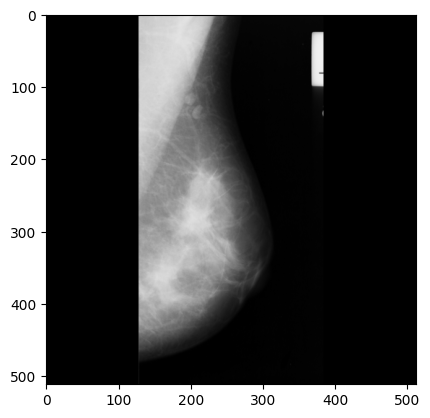

In [9]:
plt.imshow(test_set[12]/255)

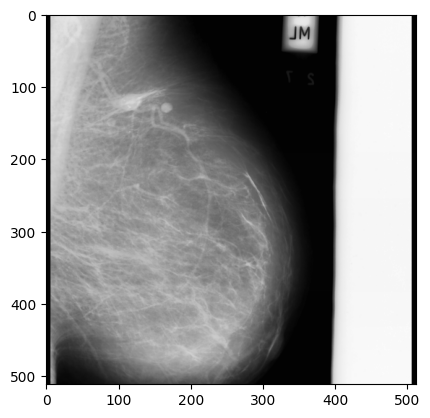

In [10]:
plt.imshow(train_set[12]/255)

In [11]:
# plt.figure(figsize=(10, 10))
# first_image = train_set[10]
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#   plt.imshow(augmented_image[0] / 255)
#   plt.axis('off')

In [12]:
# train_set_new = []
# train_set_new = tf.cast(train_set_new,tf.float32)
# train_label_new =  numpy.array((4*len(train_set)))
# i=0
# for img in train_set:
#   if(i==0):
#     train_set_new = tf.stack((img,
#                               data_augmentation(img),
#                               data_augmentation(img),
#                               data_augmentation(img)),0)
#   else:
#     train_set_new = tf.concat((train_set_new,
#                               [img,
#                               data_augmentation(img),
#                               data_augmentation(img),
#                               data_augmentation(img)]),0)
#   i+=1
# train_label_new = tf.repeat(train_label,4)
# train_label_new = tf.convert_to_tensor(train_label_new,dtype=tf.float32)
# test_label = tf.convert_to_tensor(test_label,dtype=tf.float32)
# test_label_new =  numpy.array((4*len(test_set)))
# i=0
# for img in test_set:
#   if(i==0):
#     test_set_new = tf.stack((img,
#                               data_augmentation(img),
#                               data_augmentation(img),
#                               data_augmentation(img)),0)
#   else:
#     test_set_new = tf.concat((test_set_new,
#                               [img,
#                               data_augmentation(img),
#                               data_augmentation(img),
#                               data_augmentation(img)]),0)
#   i+=1
# test_label_new = tf.repeat(test_label,4)

In [13]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_set_new, train_label_new))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_set_new, test_label_new))
train_dataset = tf.data.Dataset.from_tensor_slices((train_set, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_set, test_label))
BATCH_SIZE = 4
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=3)
test_dataset = test_dataset.prefetch(buffer_size=3)

In [14]:
preprocessing = tf.keras.applications.inception_v3.preprocess_input
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=(output_size,output_size,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-64]:
    layer.trainable = False
pre_trained.summary()


# preprocessing = tf.keras.applications.vgg16.preprocess_input
# pre_trained = VGG16(weights='imagenet', include_top=False, input_shape=(output_size,output_size,3))
# # Freeze all the layers except the last 2 layers
# for layer in pre_trained.layers[:-2]:
#     layer.trainable = False
# pre_trained.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [15]:
# train_dataset.save('/content/drive/MyDrive/MIASData/TrainData')

tfinput = Input(shape=(output_size,output_size,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
# print(x)
x=pre_trained(x,training=True)
# print(x)
x = Flatten()(x)
print(x)
x = Dense(255, activation="relu")(x)
x = Dropout(0.8)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(tfinput,output)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 2e-7),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

history = model.fit(train_dataset
                    ,epochs=50
                    ,validation_data=test_dataset
                    # ,callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
                    )



KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 401408), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Func

2023-01-11 13:24:27.480357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-11 13:24:30.417896: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-01-11 13:24:30.549458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-11 13:24:30.555608: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4419aeef40 initialized for platform CUDA (this does not guarantee

20/20 [==============================] - 11s 99ms/step - loss: 1.2696 - accuracy: 0.3375 - val_loss: 0.8827 - val_accuracy: 0.5500
Epoch 2/50
20/20 [==============================] - 1s 56ms/step - loss: 0.6581 - accuracy: 0.7250 - val_loss: 0.9776 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 1s 55ms/step - loss: 0.6692 - accuracy: 0.7000 - val_loss: 1.0555 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 1s 56ms/step - loss: 0.4410 - accuracy: 0.8125 - val_loss: 1.0838 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 1s 55ms/step - loss: 0.5083 - accuracy: 0.8125 - val_loss: 1.0941 - val_accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 1s 56ms/step - loss: 0.5021 - accuracy: 0.8125 - val_loss: 1.0688 - val_accuracy: 0.5000
Epoch 7/50
20/20 [==============================] - 1s 56ms/step - loss: 0.4273 - accuracy: 0.8125 - val_loss: 1.0210 - val_accuracy: 0.5000
Epoch 8/50
20/20 [=====

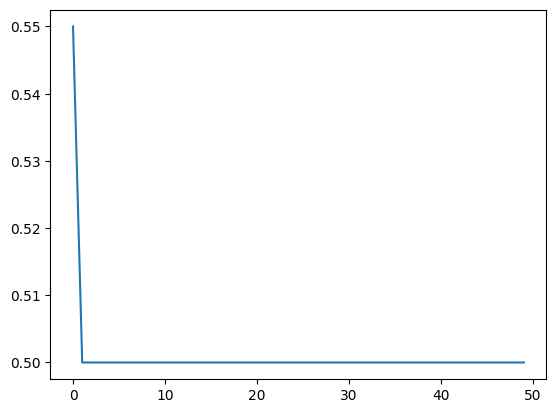

In [18]:
Accuracy = history.history['val_accuracy']
plt.plot(Accuracy)
plt.show()

Epoch 50/150
20/20 [==============================] - 1s 55ms/step - loss: 0.0538 - accuracy: 0.9875 - val_loss: 1.3252 - val_accuracy: 0.5000
Epoch 51/150
20/20 [==============================] - 1s 55ms/step - loss: 0.0743 - accuracy: 0.9625 - val_loss: 1.3822 - val_accuracy: 0.5000
Epoch 52/150
20/20 [==============================] - 1s 56ms/step - loss: 0.0602 - accuracy: 0.9875 - val_loss: 1.3922 - val_accuracy: 0.5000
Epoch 53/150
20/20 [==============================] - 1s 55ms/step - loss: 0.0767 - accuracy: 0.9750 - val_loss: 1.3589 - val_accuracy: 0.5000
Epoch 54/150
20/20 [==============================] - 1s 56ms/step - loss: 0.0745 - accuracy: 0.9875 - val_loss: 1.3287 - val_accuracy: 0.5000
Epoch 55/150
20/20 [==============================] - 1s 56ms/step - loss: 0.0648 - accuracy: 0.9875 - val_loss: 1.3315 - val_accuracy: 0.5000
Epoch 56/150
20/20 [==============================] - 1s 55ms/step - loss: 0.0530 - accuracy: 0.9875 - val_loss: 1.3525 - val_accuracy: 0.5000

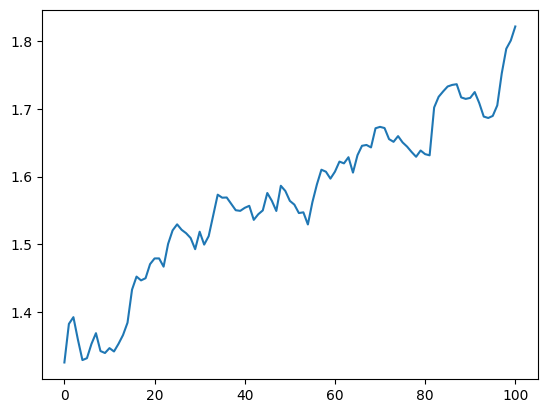

In [17]:
fine_tune_epochs = 100
initial_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Accuracy = history_fine.history['val_loss']
plt.plot(Accuracy)
plt.show()